# Képi információ kezelése gépi tanuláskor

Egy digitális képet tekinthetünk pixelekből álló rendezett struktúrának. A pixel a kép egy eleme, értéke a kép színmélységétől függ. A legegyszerűbb esetben fekete-fehér kép esetén az egyes pixelek értéke $0$ (fekete) vagy $1$ (fehér).

Szürkeárnyalatos kép esetén az értéktartomány növelhető, például $[0;255]$-re, amely memóriafoglalása épp egy byte lesz. Ekkor a legkisebb érték jelenti a fekete színt, a legmagasabb érték pedig a fehéret. A fennmaradó $254$ szín pedig a szürke egy árnyalatát. Ez az úgynevezett 8-bites szürkeárnyalatos kép, hisz egy pixelhez tartozó intenzitás információ 8 biten, 1 byteon van eltárolva.

Színes képek esetén a főszínekhez tartozó R, G és B csatorna értékeit szokás külön tárolni, így például egy pixelhez tartozhat egy 8 bites R, egy 8 bites G és egy 8 bites B csatorna, ennélfogva egy pixel színi információját 3 byteon, 24 biten írjuk le.

Ha veszünk egy kicsinek számító, $640 \times 480$-as színes képet, akkor a memóriában ehhez szükséges tárhely:

In [13]:
print(640*480*3)

921600


Persze ez a tömörítetlen esetet jelöli, a valóságban a fényképezett képek jól tömöríthetőek, minimális információveszteség mellett.

Mi történne ha ezt a képet szeretnénk egy neurális hálózat bemeneteként megadni? Nyilván triviális megközelítés hogy minden leíró információt átadunk egy-egy bemeneti paraméterként, így a fentebb kapott érték lenne a bemeneti paraméterszám.

Mivel ez a gyakorlatban kivitelezhetetlen, ezért fordulhatunk esetleg a tömörítés irányába. Persze itt inkább átalakítás jöhet szóba, hisz információvesztéskor a lényegi infókat mindenképp szeretnénk megtartani.

Átalakíthatjuk például a képet szürkeárnyalatossá, ekkor (8-bit esetén) egyetlen byteon tárolnánk a színi információkat:

In [14]:
print(640*480)

307200


Harmadára csökkent a paraméterszám, de még mindig messze nagyobb, mint ami kezelhető lenne. Megoldás lehet a kép méretének csökkentése, azaz a kép zsugorítása:

In [15]:
print(128*96)

12288


A megvalósíthatóságért jelentős információvesztéssel fizetünk (TODO: ha egyszer könyvet írok, ez belekerül :D).

Megjegyzés: a gépi tanulás hosszas történelme során a kutatók kifejlesztettek különféle elemzésen módszereket az adatok információtartó transzformációjára, amellyel kisebb paraméterszám érhető el, lásd pl. főkomponens analízis.

### ImageDataGenerator

A következőekben áttekintjük a Keras által biztosított eszközöket kifejezetten képi bemenetek esetére, és megvizsgáljuk a hatékonyságot és lehetséges megoldási módszereket.

A Kerasban a középpontban az ImageDataGenerator osztály áll:

In [16]:
from keras.preprocessing.image import ImageDataGenerator

Részleteiben lásd: https://keras.io/preprocessing/image/

A példánynál meghatározható, hogy a betöltött képeken esetleg milyen átalakításokat végezzen (lásd kicsit később mint *data augmentation*)

In [17]:
train_gen = ImageDataGenerator(rescale=1./255, featurewise_std_normalization=True)

c:\Users\dezsics\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\preprocessing\image.py:1460: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, which overrides setting of `featurewise_center`.
  warnings.warn(


Az mindig jó ötlet, ha az adatokat normalizáljuk és centralizáljuk, így a hálózat gyorsabban fog tanulni.

A generátor persze csak azt mondja meg hogy mi történjen az adatokkal, maguk az adatok másutt vannak definiálva. Képek esetén például lehetséges tárolni őket mint külön állományok (értsd: képek, könyvtárakban). Más lehetőség, ha felépítünk belőlük egy nagy bináris állomány, amelyben multidimenzionális tömbben tároljuk a különböző képeket, és a címkéiket.

### MNIST Dataset

Jelen példához mi az MNIST adathalmazt fogjuk felhasználni. Ebben az adatbázisban kézzel írott számjegyek találhatóak, megcímkézve a hozzájuk tartozó numerikus értékkel, lásd: https://en.wikipedia.org/wiki/MNIST_database.

Ezen adathalmazon többféle érdekes kísérlet elvégezhető, de a gyakorlatban is hasznos megoldás születhet ha OCR (Optical Character Recognition) megoldást készítenénk számokra: a bemeneti kép alapján egy többosztályú klasszifikáció kimenete lehet a felismert számjegy.

A datasetet ZIP állományként feltöltöttem a weboldalra. A ZIPen belül az egyes alkönyvtárakban (0, 1, 2, ..., 9) az egyes szájegyekhez tartozó képek találhatóak.

*Megjegyzés*: a Keras készítői gondolnak a kísérletezőkre, így a *keras.datasets* package alatt többféle dataset is megtalálható, például az MNIST is, amely esetén a *mnist.load_data()* segítségével betölthetőek a tanítóminták.

In [18]:
import os
path = "mnist_as_jpg/trainingSet/"
os.listdir("path")

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

Izgalmas kérdés, hogy összesen - illetve osztályonként hány tanítómintánk van (lásd https://docs.python.org/3/library/os.html#os.walk):

In [19]:
[len(files) for root, dirs, files in os.walk("trainingSet")]

[]

In [20]:
["{}: {}".format(root, len(files)) for root, dirs, files in os.walk("trainingSet")]

[]

Az a helyzet, hogy a különböző mintákból különböző számú tanítóminta áll rendelkezésre. Ez semmiképp sem jó! Mindenképp úgy kell kialakítani a megoldásunkat, hogy a tanítás során az egyes epochokban osztályonként mindig azonos számú mintával tanítsunk. Minden más esetben torzul a modell.

Több megoldás lehetséges:
- növelem a tanítómintáim számát úgy, hogy azonos számot kapjak (:));
- csökkentem a tanítóminták számát a minimumra;
- epochonként véletlenszerűen veszek ki fix, kis számú mintát;
- növelem a tanítóminták számát generált adatokkal.

Valójában mindegyik megoldás alkalmazott a gyakorlatban, szóban megbeszéljük hogy miért. Mi, ezen a laboron a legegyszerűbb irányba megyünk, és csökkentjük az egyes klasszokhoz tartozó tanítóminták számát addig, amíg mindenütt azonos számú minta nem lesz.

A kidolgozott megoldás alapötlete az, hogy az egyes könyvtárakból random törlünk annyi képet, amennyi a minimálistól való eltérés:

In [21]:
min_len = min([len(files) for root, dirs, files in os.walk(path)][1:])
min_len

3795

In [22]:
import random

In [23]:
for root, dirs, files in os.walk(path):
    if (len(files) == 0):
        continue
    del_count = len(files)-min_len
    random.shuffle(files)
    for f in files[:del_count]:
        os.remove(os.path.join(root, f))

Nézzük sikerült-e:

In [24]:
["{}: {}".format(root, len(files)) for root, dirs, files in os.walk(path)]

['mnist_as_jpg/trainingSet/: 0',
 'mnist_as_jpg/trainingSet/0: 3795',
 'mnist_as_jpg/trainingSet/1: 3795',
 'mnist_as_jpg/trainingSet/2: 3795',
 'mnist_as_jpg/trainingSet/3: 3795',
 'mnist_as_jpg/trainingSet/4: 3795',
 'mnist_as_jpg/trainingSet/5: 3795',
 'mnist_as_jpg/trainingSet/6: 3795',
 'mnist_as_jpg/trainingSet/7: 3795',
 'mnist_as_jpg/trainingSet/8: 3795',
 'mnist_as_jpg/trainingSet/9: 3795']

Nézzünk meg pár mintát a maradék képekből:

In [25]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

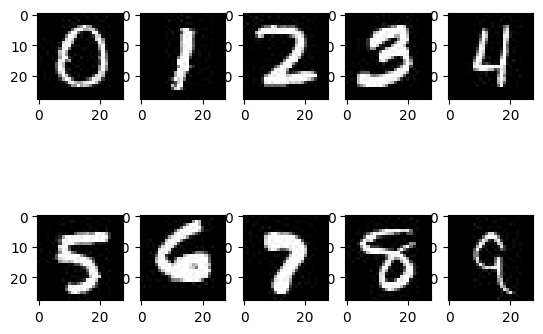

In [28]:
fig, axs = plt.subplots(2,5)
i=0
for root, dirs, files in os.walk(path):
    if (len(files) == 0):
        continue
    axs[int(i/5)][i%5].imshow(mpimg.imread(os.path.join(root, random.choice(files))), 'gray')
    i+=1

Ebben a példafeladatban nem fogunk validációs halmazt leválasztani: ha szükségünk lenne rá, egészen egyszerűen külön könyvtárba másolt képekkel meg tudnánk oldani.

A definiált generátornak van egy *.flow_from_directory()* metódusa, amely segítségével a könyvtár egyes elemeit el tudjuk érni: https://keras.io/preprocessing/image/#flow_from_directory

<pre>flow_from_directory(directory, target_size=(256, 256), color_mode='rgb', classes=None, class_mode='categorical', batch_size=32, shuffle=True, seed=None, save_to_dir=None, save_prefix='', save_format='png', follow_links=False, subset=None, interpolation='nearest')</pre>

Azaz, a képek betöltéskor átméretezhetőek (*target_size*), színmód változtatható (*color_mode*), valamint további funkciók is elérhetőek. A Keras tehát sokat segít abban, hogy a képek kezelésével ne (se) kelljen foglalkoznunk.

Mindezt pedig a modellnek a *.fit_generator()* metódusán keresztül adjuk át az eddig használt *.fit()* helyett.

In [29]:
train_data = train_gen.flow_from_directory(path,
                                           target_size=(28, 28),
                                           batch_size=512,
                                           color_mode='grayscale')

Found 37950 images belonging to 10 classes.


### Hálózati architektúra

Készítsünk architektúrát az eddig ismert elemekből. A bemeneti elemek száma $28 \times 28$, hisz az egyes pixelek kezelhetőek mint különálló leírók, szerializálva bemenetnek átadhatóak. A képek szürkeárnyalatosak, színi információt nem viszünk magunkkal.

In [ ]:
28*28

Az adatok háromdimenziós tömbként jönnek ($28 \times 28 \times 1$), míg az *Input* réteg persze egydimenziós vektort vár: kezdjük az egész modellt egy *Reshape* réteggel, ami szerializálja a bemenetként kapott tömböt.

In [ ]:
from keras import Sequential
from keras.callbacks import Callback
from keras.layers import Dense, Reshape
from keras.layers.advanced_activations import LeakyReLU

model = Sequential()
model.add(Reshape((784, ), input_shape=(28, 28, 1)))
model.add(Dense(784, input_shape=(784, )))
model.add(LeakyReLU(alpha=0.3))
model.add(Dense(400))
model.add(LeakyReLU(alpha=0.3))
model.add(Dense(10, activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

In [ ]:
model.fit_generator(train_data,
                    epochs=20)

A tanítás lassú: **SOK** a paraméter!

Hogy lehet a paraméterek számán csökkenteni? Valójában ahogy fentebb a summary is mutatja, a nagy paraméterszámot a bemeneti 784 paraméter okozza. A tanítható paraméterek számát az első rétegben ugyanis a bemenetként kapott értékek és a neuronok számának szorzata adja: $784 \times 784$, plusz az eltolás értékekkel együtt:

In [ ]:
784*784+784

Persze ezen lehet segíteni, ha a neuronszámot csökkentjük... de ezt már megtanultuk, hogy rossz megközelítés. Már ez a "sekély" hálózat is pontatlan, de mélyebb, azaz több rejtett rétegű hálózattal a paraméterszám is nő, a számításigény (és a memóriaköltség) megnő, a tanítás lassul.

És ennél a feladatnál 28 pixel széles és magas miniatűr képekről beszélünk!

Ez egy fontos probléma, amely rendhagyó megoldást kíván: következő alkalommal alaposan átnézzük!

### Teljesítmény

Betanítást követően azt látjuk, hogy a teljesítmény alacsony, próbálkozzunk meg a klasszifikációs pontosság javításával.

Az előző hálózat elég "hasraütés-szerűen" került kialakításra, próbáljunk meg mélyebb struktúrát kialakítani.

In [ ]:
model = Sequential()
model.add(Reshape((784, ), input_shape=(28, 28, 1)))
model.add(Dense(784, input_shape=(784, )))
model.add(LeakyReLU(alpha=0.3))
model.add(Dense(500))
model.add(LeakyReLU(alpha=0.3))
model.add(Dense(500))
model.add(LeakyReLU(alpha=0.3))
model.add(Dense(200))
model.add(LeakyReLU(alpha=0.3))
model.add(Dense(200))
model.add(LeakyReLU(alpha=0.3))
model.add(Dense(50))
model.add(LeakyReLU(alpha=0.3))
model.add(Dense(50))
model.add(LeakyReLU(alpha=0.3))
model.add(Dense(10, activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

In [ ]:
train_data = train_gen.flow_from_directory("trainingSet",
                                           target_size=(28, 28),
                                           batch_size=512,
                                           color_mode='grayscale')

In [ ]:
model.fit_generator(train_data,
                    epochs=20)

# Színes képek

Amennyiben színes képeket kap bemenetként a hálózat, azok 3D mátrixként érkeznek, mint $H \times W \times C$, ahol az első két dimenzió a kép méretével egyezik meg, míg a harmadik hossza $3$. Ez reprezentálja ugyanis az RGB színmód $3$ csatornáját, a <span style="color: red">vörös</span>, <span style="color: green">zöld</span>, <span style="color: blue">kék</span> színek intenzitását. E három főszín keverékéből állítjuk elő a többi színt.

Ennek illusztrálására egy másik problémát keresünk, a klasszikus ***Cats Vs Dogs*** challenge megoldásával próbálkozunk meg - klasszikus eszközökkel. A dataset zippelve elérhető a weboldalon.

Első feladat: ellenőrizzük a minták számát!

In [ ]:
["{}: {}".format(root, len(files)) for root, dirs, files in os.walk("catsvsdogs")]

Itt eleve adott a minták azonos száma, nincs dolgunk.

Esetleg nézzünk pár mintaképet:

In [ ]:
fig, axs = plt.subplots(2,2)
i=0
for root, dirs, files in os.walk("catsvsdogs"):
    if (len(files) <= 1):
        continue
    axs[int(i/2)][i%2].imshow(mpimg.imread(os.path.join(root, random.choice(files))))
    i+=1

Változóak a méretek, mindenképp át kell méretezni a bemenetre kerülő képeket. További nehezítés, hogy a bemenet mérete fix kell hogy legyen, itt a képek arányában is megfigyelhető különbség: van fekvő és álló kép is.

Definiáljuk a generátort:

In [ ]:
imsize = 64

train_gen = ImageDataGenerator(rescale=1./255, featurewise_std_normalization=True)

train_data = train_gen.flow_from_directory("catsvsdogs\\training_set",
                                           target_size=(imsize, imsize),
                                           class_mode='binary',
                                           batch_size=128)

A tesztelésre (validálásra) is lehet külön generátort definiálni, ebbe az irányba induljunk el:

In [ ]:
test_gen = ImageDataGenerator(rescale=1./255, featurewise_std_normalization=True)

test_data = train_gen.flow_from_directory("catsvsdogs\\test_set",
                                           target_size=(imsize, imsize),
                                           class_mode='binary',
                                           batch_size=128)

Lévén hogy két osztály van csak, bináris klasszifikációként is definiálhatjuk a feladatot. A problémától és a konkrét bemenetektől függően persze lehet hogy célszerű 2D vektor kimenetű vektort adni. Utóbbi esetben a modell képes arra is, hogy a nem kutya és nem macska objektumokat is helyesen jelezze.

Definiáljuk a struktúrát:

In [ ]:
param_num = imsize*imsize*3

from keras.layers import Dropout

model = Sequential()
model.add(Reshape((param_num, ), input_shape=(imsize, imsize, 3)))
model.add(Dense(4000, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(4000, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(400, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(400, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

In [ ]:
model.fit_generator(train_data,
                    epochs=20,
                    validation_data=test_data)

Folytatás innen, következő alkalommal!